In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats as t
import os
from prettytable import PrettyTable

In [2]:
def eval2(data: np.ndarray) -> np.ndarray:
    eq = np.zeros((data.shape[0], 4), dtype=np.float32)
    hp_blackMamba, hp_mctsAi, time_elapsed = data[:, 1], data[:, 2], data[:, 3]
    eq[:, 0] = hp_blackMamba / 400.0 # HP_1
    eq[:, 1] = 1 - hp_mctsAi / 400.0 # HP_2
    eq[:, 2] = hp_blackMamba > hp_mctsAi # w
    eq[:, 3] = eq[:, 2] * (1 - time_elapsed / 3600.0) + (1 - eq[:, 2]) * (time_elapsed / 3600.0) # t
    return eq.mean(axis=1)

def load1(log_dir: str) -> np.ndarray:
    lst = list()
    for i, file in enumerate(os.listdir(log_dir)):
        data = pd.read_csv(os.path.join(log_dir, file)).processing_time.to_numpy()
        lst.extend(data)
    return np.array(lst, dtype=np.float32)

def load2(log_dir: str) -> np.ndarray:
    lst = list()
    for file in os.listdir(log_dir):
        data = pd.read_csv(os.path.join(log_dir, file), header=None).to_numpy()
        lst.append(eval2(data))
    return np.array(lst, dtype=np.float32).flatten()

In [3]:
data_dir = "data\\BlackMamba"
data = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]

### gRPC

In [4]:
tab = PrettyTable(['Title', 'N', 'Mean', 'P95'])
for x in data:
    d = load1(os.path.join(x, "grpc"))[6:]
    tab.add_row([x, d.shape[0], d.mean(), np.percentile(d, 95)])
print(tab)

+---------------------------------+-------+-----------+--------------------+
|              Title              |   N   |    Mean   |        P95         |
+---------------------------------+-------+-----------+--------------------+
|    data\BlackMamba\Java-14.8    | 95001 | 15.862119 | 16.507400512695312 |
|    data\BlackMamba\Java-15.15   | 91050 |  16.13197 | 16.611799240112305 |
|    data\BlackMamba\Java-15.5    | 91109 | 16.343018 | 16.95776023864746  |
|    data\BlackMamba\Java-15.85   | 81331 | 16.703817 | 17.270400047302246 |
|  data\BlackMamba\Java-baseline  | 91771 | 3.1223745 | 3.3785499334335327 |
|   data\BlackMamba\Python-15.15  | 93895 | 16.093006 | 16.732330131530762 |
|   data\BlackMamba\Python-15.5   | 93063 | 16.463757 | 16.917400360107422 |
|   data\BlackMamba\Python-15.85  | 81636 | 16.834833 | 17.22570037841797  |
| data\BlackMamba\Python-baseline | 92518 | 3.0866756 | 3.401900053024292  |
+---------------------------------+-------+-----------+--------------------+

### Point (Mean of score each round)

In [5]:
tab = PrettyTable(['Title', 'N', 'Mean', 'Std'])
for x in data:
    d = load2(os.path.join(x, "point"))[6:]
    tab.add_row([x, d.shape[0], d.mean(), d.std()])
print(tab)

+---------------------------------+----+------------+-------------+
|              Title              | N  |    Mean    |     Std     |
+---------------------------------+----+------------+-------------+
|    data\BlackMamba\Java-14.8    | 90 | 0.90532947 | 0.026717588 |
|    data\BlackMamba\Java-15.15   | 90 | 0.89890283 | 0.031970356 |
|    data\BlackMamba\Java-15.5    | 90 | 0.8699329  | 0.036144897 |
|    data\BlackMamba\Java-15.85   | 90 | 0.8328603  | 0.048668332 |
|  data\BlackMamba\Java-baseline  | 90 | 0.92192364 | 0.020106765 |
|   data\BlackMamba\Python-15.15  | 90 | 0.8993265  | 0.037678823 |
|   data\BlackMamba\Python-15.5   | 90 | 0.8659243  |  0.0423973  |
|   data\BlackMamba\Python-15.85  | 90 | 0.83140665 | 0.058458816 |
| data\BlackMamba\Python-baseline | 90 | 0.92000234 | 0.025483659 |
+---------------------------------+----+------------+-------------+


##### with delay

In [6]:
data1 = [
    "data/BlackMamba/Java-baseline/point",
    "data/BlackMamba/Java-15.15/point",
    "data/BlackMamba/Java-15.5/point",
    "data/BlackMamba/Java-15.85/point",
]
y1_mean = np.array([load2(x)[6:].mean() for x in data1])
y1_stderr = np.array([t.sem(load2(x)[6:]) for x in data1])

In [7]:
data2 = [
    "data/BlackMamba/Python-baseline/point",
    "data/BlackMamba/Python-15.15/point",
    "data/BlackMamba/Python-15.5/point",
    "data/BlackMamba/Python-15.85/point",
]
y2_mean = np.array([load2(x)[6:].mean() for x in data2])
y2_stderr = np.array([t.sem(load2(x)[6:]) for x in data2])

In [8]:
print("Java:", y1_mean)
print("Python:", y2_mean)

Java: [0.92192364 0.89890283 0.8699329  0.8328603 ]
Python: [0.92000234 0.8993265  0.8659243  0.83140665]


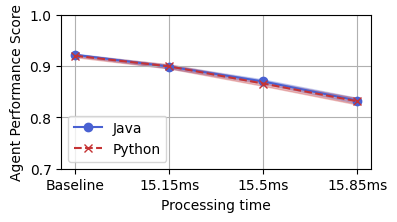

In [9]:
fig, ax = plt.subplots(figsize=(4, 2))
color_map = mpl.colormaps['coolwarm']
ax.set_xlabel("Processing time")
ax.set_ylabel("Agent Performance Score")
ax.set_ylim(0.70, 1.0)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["Baseline", "15.15ms", "15.5ms", "15.85ms"])
ax.set_yticks(np.arange(0.70, 1.01, step=0.1))
ax.plot(np.arange(4), y1_mean, '-o', color=color_map(0.05), label='Java')
ax.plot(np.arange(4), y2_mean, '--x', color=color_map(0.95), label='Python')
ax.fill_between(np.arange(4), y1_mean-y1_stderr, y1_mean+y1_stderr, color=color_map(0.05), alpha=0.3)
ax.fill_between(np.arange(4), y2_mean-y2_stderr, y2_mean+y2_stderr, color=color_map(0.95), alpha=0.3)
ax.legend(loc="lower left")
ax.grid(True)

##### without delay

In [10]:
data1 = [
    "data/BlackMamba/Java-baseline/point",
    "data/BlackMamba/Java-14.8/point",
    "data/BlackMamba/Java-15.15/point",
    "data/BlackMamba/Java-15.5/point",
]
y1_mean = np.array([load2(x)[6:].mean() for x in data1])
y1_stderr = np.array([t.sem(load2(x)[6:]) for x in data1])

In [11]:
print("Java:", y1_mean)
print("Python:", y2_mean)

Java: [0.92192364 0.90532947 0.89890283 0.8699329 ]
Python: [0.92000234 0.8993265  0.8659243  0.83140665]


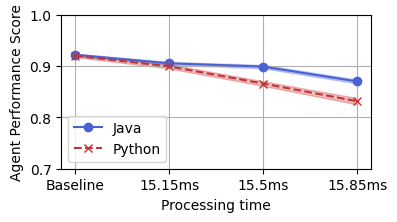

In [12]:
fig, ax = plt.subplots(figsize=(4, 2))
color_map = mpl.colormaps['coolwarm']
ax.set_xlabel("Processing time")
ax.set_ylabel("Agent Performance Score")
ax.set_ylim(0.70, 1.0)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["Baseline", "15.15ms", "15.5ms", "15.85ms"])
ax.set_yticks(np.arange(0.70, 1.01, step=0.1))
ax.plot(np.arange(4), y1_mean, '-o', color=color_map(0.05), label='Java')
ax.plot(np.arange(4), y2_mean, '--x', color=color_map(0.95), label='Python')
ax.fill_between(np.arange(4), y1_mean-y1_stderr, y1_mean+y1_stderr, color=color_map(0.05), alpha=0.3)
ax.fill_between(np.arange(4), y2_mean-y2_stderr, y2_mean+y2_stderr, color=color_map(0.95), alpha=0.3)
ax.legend(loc="lower left")
ax.grid(True)